### Pre-process Pipeline

In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


# These are length cols so their values must be 0 or +ve
cols_non_negative = ['tcp_time_delta', 'tcp_len', 'mqtt_len', 'mqtt_proto_len', 'mqtt_willmsg_len', 'mqtt_willtopic_len']

# nominal_cols = ['tcp_flags', 'mqtt_conack_flags', 'mqtt_conflags', 'mqtt_hdrflags']
# The other 2 are not useful --> (for more than 99% of the entries, they are 0)
# mqtt_hdrflags --> 37% of the entries are not in hex format but we will 1 hot encode it
nominal_cols = ['tcp_flags', 'mqtt_hdrflags']

continous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp',\
                'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 'mqtt_conflag_reserved', \
                'mqtt_conflag_retain', 'mqtt_conflag_uname', 'mqtt_conflag_willflag', 'mqtt_dupflag', \
                'mqtt_kalive', 'mqtt_len', 'mqtt_msg', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_proto_len', \
                'mqtt_qos', 'mqtt_retain', 'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_willmsg', \
                'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'mqtt_ver', 'mqtt_conack_val']

def convert_string(s):
    return 0 if s == '0' else 1

def convert_target_to_label(target):
    if target == 'slowite':
        return 0
    elif target == 'bruteforce':
        return 1
    elif target == 'flood':
        return 2
    elif target == 'malformed':
        return 3
    elif target == 'dos':
        return 4
    elif target == 'legitimate':
        return 5
    else:
        return 6
    
class RenameDatasetCols(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        all_cols = output_df.columns
        for column in all_cols:
            new_column = column.replace('.', '_')
            output_df = output_df.withColumnRenamed(column, new_column)
        # print(output_df.columns)
        return output_df

class OutcomeCreator(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_classes = udf(convert_target_to_label, IntegerType())
        output_df = dataset.withColumn('label', label_to_classes(dataset['target'])).drop('target')
        output_df = output_df.withColumn('label', output_df['label'].cast(DoubleType()))
        return output_df
    
class ConstraintChecker(Transformer):
    def __init__(self, columns_to_check = None):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in cols_non_negative:
            output_df = output_df.filter(output_df[col_name] >= 0)
        return output_df
    
class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            if col_name in output_df.columns:
                output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():

    # Stage where we rename the columns
    stage_column_renamer = RenameDatasetCols()

    # Stage where we handle nominal values
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continous_cols + nominal_onehot_cols

    # These cols have only 1 unique value
    cols_single_val = ['mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conflag_qos', \
                       'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_willflag', 'mqtt_sub_qos', \
                        'mqtt_suback_qos', 'mqtt_willmsg', 'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len']
    
    # Highly correlaterd columns
    cols_high_corr = ['mqtt_conflag_cleansess', 'mqtt_proto_len', 'mqtt_conflag_passwd', 'mqtt_len']
    
    # Not useful columns
    cols_not_useful = ['mqtt_msg']

    # These are supposed to be in form 0x0000XX but > 99% are 0
    cols_hex_constraints_not_met = ['mqtt_conack_flags', 'mqtt_conflags']

    # > 99% of the entries are 0
    cols_more_than_99_zero = ['mqtt_conack_val', 'mqtt_conflag_uname', 'mqtt_kalive', 'mqtt_protoname', 'mqtt_retain', 'mqtt_ver']
    
    cols_to_remove = cols_single_val + cols_high_corr + cols_not_useful + cols_hex_constraints_not_met + nominal_cols\
                     + nominal_id_cols + cols_more_than_99_zero
    
    for col_name in cols_to_remove:
        if col_name in feature_cols:
            feature_cols.remove(col_name)

    print(feature_cols)
    # Stage where we assemble all the features into a vector

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='vectorized_features')

    # Stage where we scale the features
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage where we create the label column
    stage_label_creator = OutcomeCreator()

    # Removing all unnecessary columns, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = continous_cols + ['vectorized_features'] + nominal_cols\
                                         + nominal_id_cols + nominal_onehot_cols + cols_to_remove)

    # Connecting the columns into a pipeline
    pipeline = Pipeline(stages = [stage_column_renamer, stage_nominal_indexer,\
                                   stage_nominal_onehot_encoder, stage_vector_assembler, stage_scaler,\
                                      stage_label_creator, stage_column_dropper])
    
    return pipeline    


In [2]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

mqtt_train_raw = spark.read.csv("train70_reduced.csv" ,header=True, inferSchema= True)
mqtt_test_raw = spark.read.csv("test30_reduced.csv", header=True, inferSchema=True)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_train_raw)

mqtt_train_df = preprocess_pipeline_model.transform(mqtt_train_raw)
mqtt_test_df = preprocess_pipeline_model.transform(mqtt_test_raw)

c:\Users\619ar\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


['tcp_time_delta', 'tcp_len', 'mqtt_dupflag', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_qos', 'tcp_flags_encoded', 'mqtt_hdrflags_encoded']


In [3]:
print(mqtt_train_df.count())
print(mqtt_test_df.count())
# to find how many records of each label are there

mqtt_train_df.groupBy('label').count().orderBy("label").show()

231646
99290
+-----+------+
|label| count|
+-----+------+
|  0.0|  6441|
|  1.0| 10150|
|  2.0|   429|
|  3.0|  7646|
|  4.0| 91156|
|  5.0|115824|
+-----+------+



### Spark Models

In [5]:
class_names=[0,1,2,3,4,5]
class_names_str=["slowite","bruteforce", "flood", "malformed", "dos", "legitimate"]

# plot a confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def plot_confusion_matrix(cm, classes = class_names_str,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Input the model, the dataframe, the classes, and the title of the plot.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def model_performance(model, df_train, df_test = None, model_name = None):
    """
    This function prints the accuracy and confusion matrix of the model on the training and test set.
    Input the model, the dataframe(s).

    """
    # Training accuracy
    pred_train = model.transform(df_train)
    acc_train = pred_train.filter(pred_train.label == pred_train.prediction).count()/pred_train.count()
    print(f"Training Accuracy: {np.round(100*acc_train,2)}%")

    # Precision, recall, f1-score
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    precision_train = evaluator.evaluate(pred_train, {evaluator.metricName: "weightedPrecision"})
    recall_train = evaluator.evaluate(pred_train, {evaluator.metricName: "weightedRecall"})
    f1_train = evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})
    
    print(f"Training Precision: {np.round(100*precision_train,2)}%")
    print(f"Training Recall: {np.round(100*recall_train,2)}%")
    print(f"Training F1-Score: {np.round(f1_train,2)}")


    # Plot confusion matrix for training set    
    class_names=[0,1,2,3,4,5]
    class_names_str=["slowite","bruteforce", "flood", "malformed", "dos", "legitimate"]
    
    outcome_true_train = pred_train.select('label').toPandas()
    outcome_pred_train = pred_train.select('prediction').toPandas()

    cnf_matrix_train = confusion_matrix(outcome_true_train, outcome_pred_train, labels=class_names)
    plt.figure()
    if model_name is not None:
        plot_confusion_matrix(cnf_matrix_train, classes=class_names_str,
                      title=f'{model_name} Confusion matrix (training set)')
    else:
        plot_confusion_matrix(cnf_matrix_train, classes=class_names_str,
                      title='Confusion matrix (training set)')
    plt.show()    
    
    # Test accuracy
    if df_test is not None:
        pred_test = model.transform(df_test)
        acc_test = pred_test.filter(pred_test.label == pred_test.prediction).count()  / pred_test.count()
        print(f"Test Accuracy: {np.round(100*acc_test,2)}%")

        # Precision, recall, f1-score
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
        precision_test = evaluator.evaluate(pred_test, {evaluator.metricName: "weightedPrecision"})
        recall_test = evaluator.evaluate(pred_test, {evaluator.metricName: "weightedRecall"})
        f1_test = evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})
        print(f"Test Precision: {np.round(100*precision_test,2)}%")
        print(f"Test Recall: {np.round(100*recall_test,2)}%")
        print(f"Test F1-Score: {np.round(f1_test,2)}")

        # Plot confusion matrix for test set
        outcome_true_test = pred_test.select('label').toPandas()
        outcome_pred_test = pred_test.select('prediction').toPandas()

        cnf_matrix_test = confusion_matrix(outcome_true_test, outcome_pred_test, labels=class_names)
        plt.figure()
        if model_name is not None:
            plot_confusion_matrix(cnf_matrix_test, classes=class_names_str,
                          title=f'{model_name} Confusion matrix (test set)')
        else:
            plot_confusion_matrix(cnf_matrix_test, classes=class_names_str,
                          title='Confusion matrix (test set)')
        plt.show()
    

### Random Forests (UnTuned)

Training Accuracy: 86.01%
Training Precision: 88.24%
Training Recall: 86.01%
Training F1-Score: 0.85
Confusion matrix, without normalization
[[  1350   2325      0      0      0   2766]
 [     0   6343      0      0    352   3455]
 [     1      3      0      0      1    424]
 [     0   3055      0   1804     38   2749]
 [     0     64      0      0  73971  17121]
 [     0      0      0      0     49 115775]]


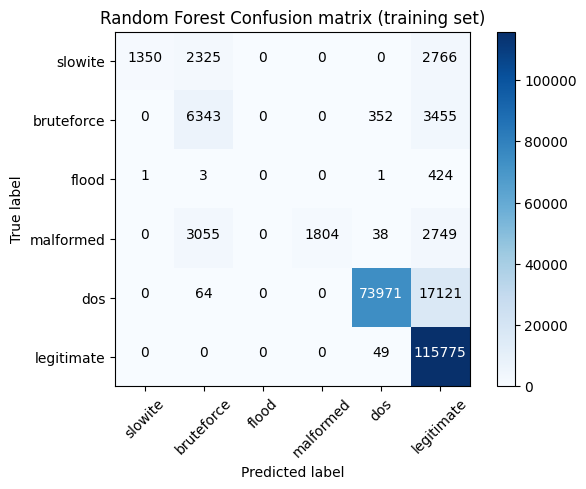

Test Accuracy: 86.78%
Test Precision: 88.69%
Test Recall: 86.78%
Test F1-Score: 0.85
Confusion matrix, without normalization
[[  473   964     0     8     0  1316]
 [    0  2629     0     5   138  1579]
 [    0     2     0     0     0   182]
 [    0  1333     0   803    16  1126]
 [    0    29     0     0 32636  6412]
 [    0     0     0     0    14 49625]]


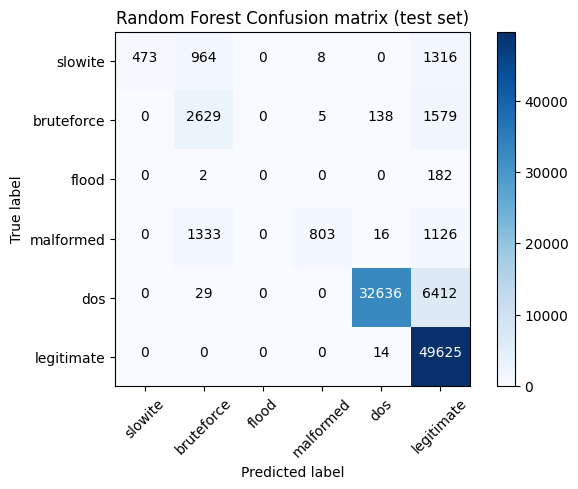

In [6]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rf_model = rf.fit(mqtt_train_df)
model_performance(model=rf_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Random Forest')

### Decision Tree (UnTuned)

Training Accuracy: 89.8%
Training Precision: 90.6%
Training Recall: 89.8%
Training F1-Score: 0.89
Confusion matrix, without normalization
[[   769   4241      0    192     73   1166]
 [   562   8751      0    216    597     24]
 [     1      7    207      3      7    204]
 [   372   4446      1   1744    459    624]
 [     0   1717      0     25  81473   7941]
 [     0    112      0      5    625 115082]]


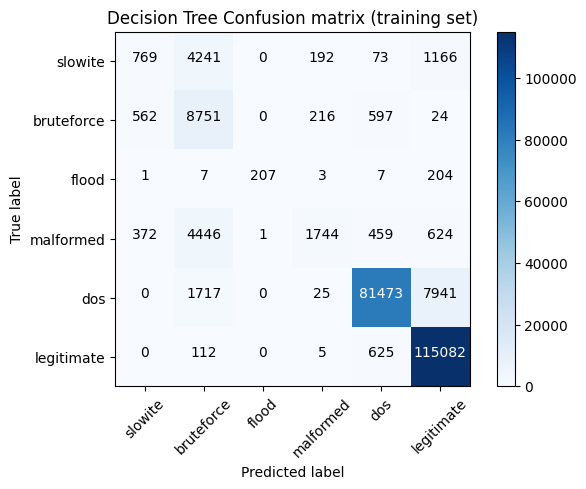

Test Accuracy: 89.09%
Test Precision: 88.99%
Test Recall: 89.09%
Test F1-Score: 0.88
Confusion matrix, without normalization
[[   76  1832     0    59    74   720]
 [  209  3710     0   138   283    11]
 [    0     2    86     3     0    93]
 [  202  1898     0   759   179   240]
 [    5   480     0     2 34488  4102]
 [    0    50     0     2   249 49338]]


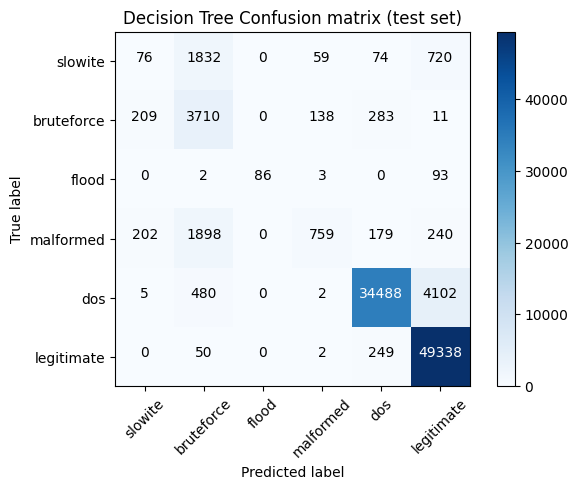

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50559)
Traceback (most recent call last):
  File "c:\Users\619ar\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Users\619ar\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Users\619ar\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Users\619ar\anaconda3\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "c:\Users\619ar\anaconda3\lib\site-packages\pyspark\accumulators.py", line 281, in handle
    poll(accum_updates)
  File "c:\Users\619ar\anaconda3\lib\site-packages\pyspark\accumulators.py", line 253, in poll
    if func():
  File "c:\Users\619ar\anaconda3\lib\site-packages\pyspark\accumulators.py", line 257, in accum_updates
  

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dt_model = dt.fit(mqtt_train_df)
model_performance(model=dt_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Decision Tree')

## Tuning

### Random Forest

Tunable Parameters:
1. maxDepth : Maximum depth of each decision tree.
2. numTrees: Number of trees in forest.

In [10]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

rf_paramGrid = (ParamGridBuilder() \
    .addGrid(rf.maxDepth, [15, 20, 25]) \
    .addGrid(rf.numTrees, [25, 40, 65]) \
    .build())

rf_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
rf_cv = CrossValidator(estimator = rf, estimatorParamMaps = rf_paramGrid, evaluator = rf_evaluator, numFolds = 5)

In [11]:
rf_cv_model = rf_cv.fit(mqtt_train_df)

Training Accuracy: 90.57%
Training Precision: 90.83%
Training Recall: 90.57%
Training F1-Score: 0.9
Confusion matrix, without normalization
[[  2577   1098      0      0   1643   1123]
 [     0   6323      0     20   3787     20]
 [     2      2    137      0     13    275]
 [     1   2357      0   2559   2053    676]
 [     0     62      0      2  83495   7597]
 [     0      0      0      0   1105 114719]]


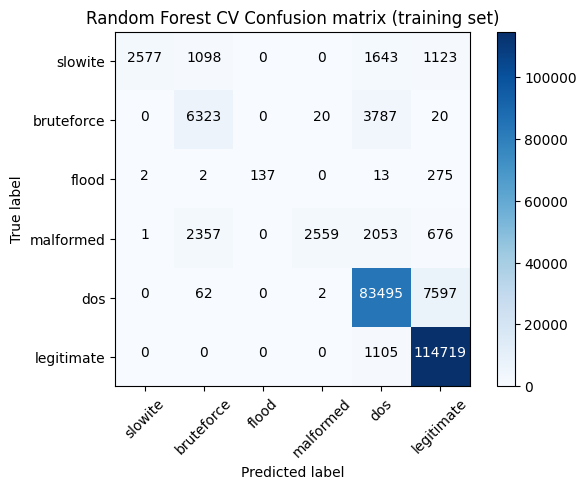

Test Accuracy: 89.8%
Test Precision: 89.97%
Test Recall: 89.8%
Test F1-Score: 0.89
Confusion matrix, without normalization
[[ 1102   317     0    26   639   677]
 [    0  2608     0    27  1654    62]
 [    0     2    57     0     0   125]
 [    2   980     0  1177   853   266]
 [    0    27     0     2 35057  3991]
 [    0     0     0     0   476 49163]]


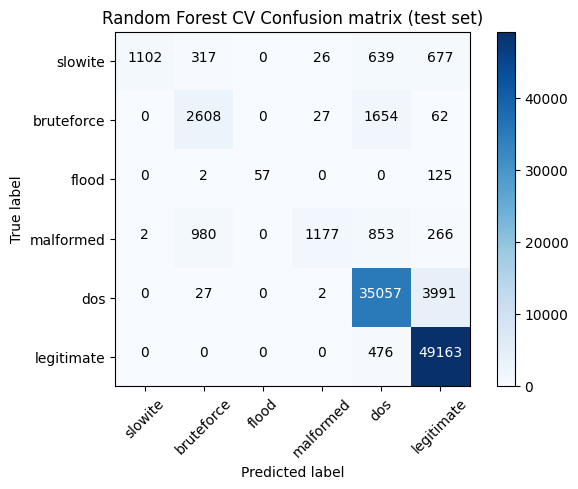

In [12]:
model_performance(model=rf_cv_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Random Forest CV')

### Decision Tree

Tunable Parameters:
1. maxDepth: Maximum depth of the tree
2. maxBins: Number of bins for splitting continous features.
3. minInstancesPerNode: Min number of instances a child must collect before splitting

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

dt_paramGrid = (ParamGridBuilder() \
    .addGrid(dt.maxDepth, [15, 20, 25, 30]) \
    .addGrid(dt.maxBins, [32, 48, 64, 72]) \
    .build())

dt_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
dt_cv = CrossValidator(estimator = dt, estimatorParamMaps = dt_paramGrid, evaluator = dt_evaluator, numFolds = 5)

In [17]:
dt_cv_model = dt_cv.fit(mqtt_train_df)

Training Accuracy: 92.84%
Training Precision: 93.05%
Training Recall: 92.84%
Training F1-Score: 0.93
Confusion matrix, without normalization
[[  4159    995      0     48    308    931]
 [   178   8578      0    397    984     13]
 [     6      1    212      0     58    152]
 [   261   2436      0   4194    623    132]
 [   488    619      0     23  83619   6407]
 [     0      0      0      0   1519 114305]]


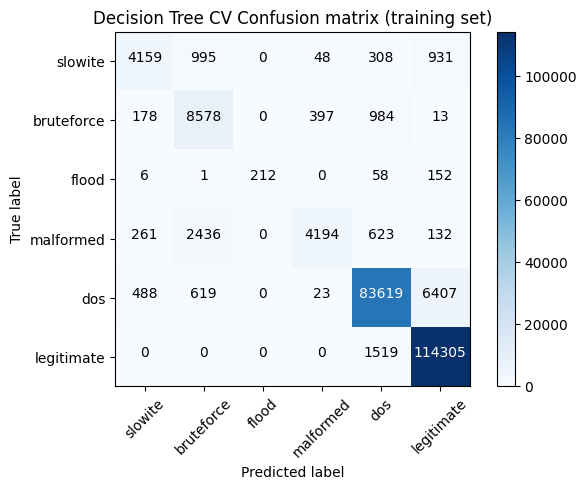

Test Accuracy: 92.19%
Test Precision: 92.18%
Test Recall: 92.19%
Test F1-Score: 0.92
Confusion matrix, without normalization
[[ 1753   149     0    65   227   567]
 [   94  3380     0   336   491    50]
 [    0     1    89     2    21    71]
 [  132  1052     1  1817   244    32]
 [  114   181     0    10 35504  3268]
 [    0     0     0     1   642 48996]]


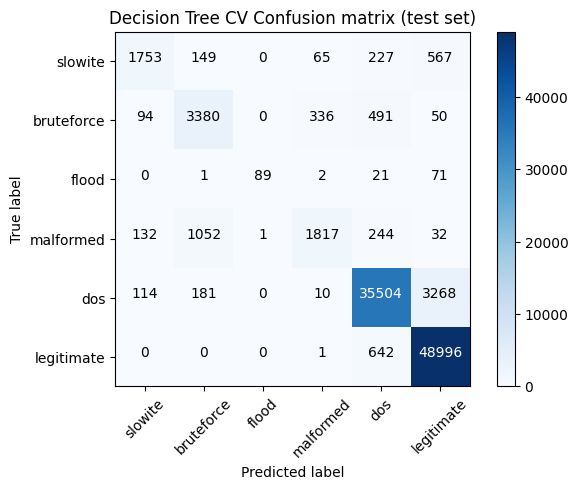

In [18]:
model_performance(model=dt_cv_model, df_train=mqtt_train_df, df_test=mqtt_test_df, model_name='Decision Tree CV')